In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
DATA_DIR = "data/train"
DOMAIN_A_DIR = "data/train/A"
DOMAIN_B_DIR = "data/train/B"

In [4]:
PROCESS_DATA = 1
TRAIN_DATA = 1
IMG_SIZE = 128
BATCH_SIZE = 1

In [5]:
data_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.CenterCrop((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
if PROCESS_DATA:
    dataset_A = datasets.ImageFolder(DOMAIN_A_DIR, transform=data_transform)
    dataloader_A = data.DataLoader(dataset_A, batch_size=BATCH_SIZE, num_workers= 2, shuffle= True)
    dataset_B = datasets.ImageFolder(DOMAIN_B_DIR, transform=data_transform)
    dataloader_B = data.DataLoader(dataset_B, batch_size=BATCH_SIZE, num_workers= 2, shuffle= True)

In [7]:
print("Domain A size: {}".format(len(dataset_A)))
print("Domain B size: {}".format(len(dataset_B)))

Domain A size: 1067
Domain B size: 1334


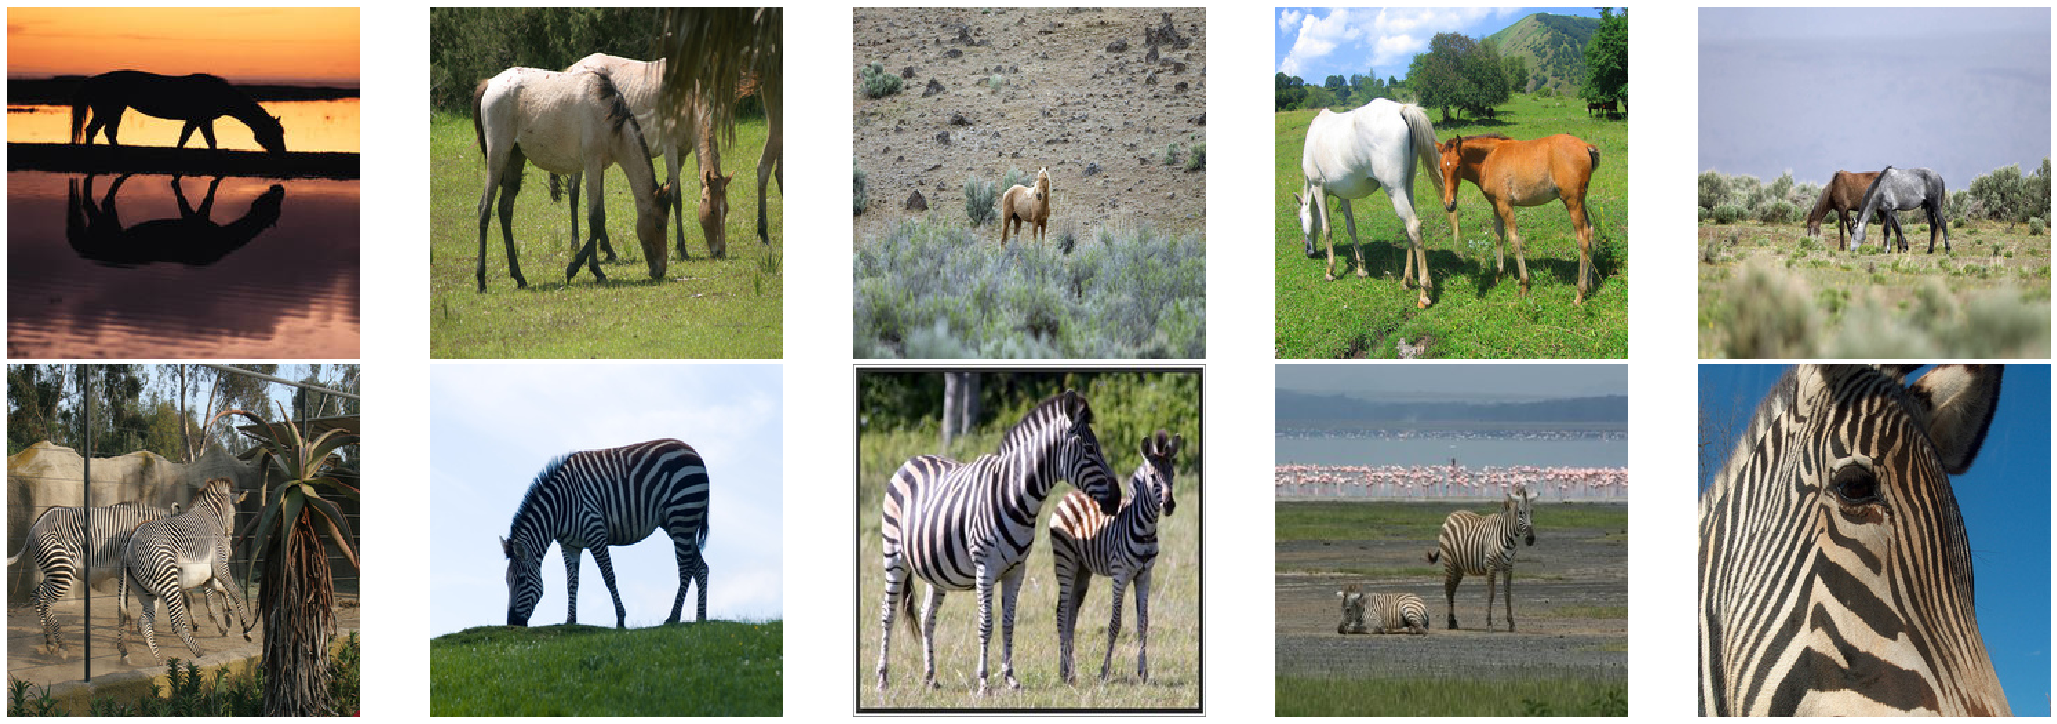

In [8]:
a = np.random.randint(1000)
fig = plt.figure(figsize=(30,10))
count = 1
for i in ["A/horse", "B/zebra"]:
    path = os.listdir(os.path.join(DATA_DIR, i))
    for f in path[a:a+5]:
        path1 = os.path.join(DATA_DIR, i,f)
        img = Image.open(path1)
        fig.add_subplot(2,5,count)
        plt.imshow(img)
        plt.axis("off")
        count+=1
fig.tight_layout(pad=0.5)   
plt.show()
        

In [9]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = np.random.uniform(0, 1)
                if p > 0.5:
                    random_id = np.random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

In [10]:
class ConvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,activation='relu',batch_norm=True):
        super(ConvBlock,self).__init__()
        self.conv = torch.nn.Conv2d(input_size,output_size,kernel_size,stride,padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
        self.lrelu = torch.nn.LeakyReLU(0.2,True)
        self.tanh = torch.nn.Tanh()
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.conv(x))
        else:
            out = self.conv(x)
        
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

In [11]:
class DeconvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,output_padding=1,activation='relu',batch_norm=True):
        super(DeconvBlock,self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size,output_size,kernel_size,stride,padding,output_padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.deconv(x))
        else:
            out = self.deconv(x)
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

In [12]:
class ResnetBlock(torch.nn.Module):
    def __init__(self,num_filter,kernel_size=3,stride=1,padding=0):
        super(ResnetBlock,self).__init__()
        conv1 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        conv2 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        bn = torch.nn.InstanceNorm2d(num_filter)
        relu = torch.nn.ReLU(True)
        pad = torch.nn.ReflectionPad2d(1)
        
        self.resnet_block = torch.nn.Sequential(
            pad,
            conv1,
            bn,
            relu,
            pad,
            conv2,
            bn
            )
    def forward(self,x):
        out = self.resnet_block(x)
        return out

In [13]:
class Generator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim,num_resnet):
        super(Generator,self).__init__()
        
        #Reflection padding
        self.pad = torch.nn.ReflectionPad2d(3)
        #Encoder
        self.conv1 = ConvBlock(input_dim,num_filter,kernel_size=7,stride=1,padding=0)
        self.conv2 = ConvBlock(num_filter,num_filter*2)
        self.conv3 = ConvBlock(num_filter*2,num_filter*4)
        #Resnet blocks
        self.resnet_blocks = []
        for i in range(num_resnet):
            self.resnet_blocks.append(ResnetBlock(num_filter*4))
        self.resnet_blocks = torch.nn.Sequential(*self.resnet_blocks)
        #Decoder
        self.deconv1 = DeconvBlock(num_filter*4,num_filter*2)
        self.deconv2 = DeconvBlock(num_filter*2,num_filter)
        self.deconv3 = ConvBlock(num_filter,output_dim,kernel_size=7,stride=1,padding=0,activation='tanh',batch_norm=False)
    
    def forward(self,x):
        #Encoder
        enc1 = self.conv1(self.pad(x))
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        #Resnet blocks
        res = self.resnet_blocks(enc3)
        #Decoder
        dec1 = self.deconv1(res)
        dec2 = self.deconv2(dec1)
        out = self.deconv3(self.pad(dec2))
        return out
    
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
            if isinstance(m,DeconvBlock):
                torch.nn.init.normal_(m.deconv.weight,mean,std)
            if isinstance(m,ResnetBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
                torch.nn.init.constant_(m.conv.bias,0)

In [14]:
class Discriminator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim):
        super(Discriminator,self).__init__()
        conv1 = ConvBlock(input_dim,num_filter,kernel_size=4,stride=2,padding=1,activation='lrelu',batch_norm=False)
        conv2 = ConvBlock(num_filter,num_filter*2,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv3 = ConvBlock(num_filter*2,num_filter*4,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv4 = ConvBlock(num_filter*4,num_filter*8,kernel_size=4,stride=1,padding=1,activation='lrelu')
        conv5 = ConvBlock(num_filter*8,output_dim,kernel_size=4,stride=1,padding=1,activation='no_act',batch_norm=False)
        self.conv_blocks = torch.nn.Sequential(
            conv1,
            conv2,
            conv3,
            conv4,
            conv5
            )
    def forward(self,x):
        out = self.conv_blocks(x)
        return out
        
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight.data,mean,std)

In [15]:
def generate_labels(size, label):
    if label == 1:
        data = torch.ones(size) - 0.1
    elif label == 0:
        data = torch.zeros(size)
    data = Variable(data).to(device)
    return data

In [16]:
def train_generator(D_A,D_B,G_A2B,G_B2A,optimizer_A,optimizer_B,error,cyclic_error,real_A, fake_A, real_B, fake_B):
    batch_size = real_A.size(0)
    G_A2B.zero_grad()
    G_B2A.zero_grad()
    
   """ # Identity losses #
    replicate_B       = G_A2B(real_B)
    loss_identity_B   = cyclic_error(replicate_B, real_B) * 5
        
    replicate_A       = G_B2A(real_A)
    loss_identity_A   = cyclic_error(replicate_A, real_A) * 5"""
    
    # Transform losses #
    predict_fake_B = D_B(fake_B)
    loss_G_A = error(predict_fake_B,generate_labels(predict_fake_B.size(),1))
    
    predict_fake_A = D_A(fake_A)
    loss_G_B = error(predict_fake_A,generate_labels(predict_fake_A.size(),1))
    
    # Cycle losses #
    cyclic_A = G_B2A(fake_B)
    loss_cyclic_A = cyclic_error(real_A,cyclic_A) * 10
    
    cyclic_B = G_A2B(fake_A)
    loss_cyclic_B = cyclic_error(cyclic_B,real_B) *10
    
    # Total Losses #
    loss_G = loss_G_A + loss_G_B + loss_cyclic_A + loss_cyclic_B #+ loss_identity_A + loss_identity_B
    loss_G.backward()
    optimizer_A.step()
    optimizer_B.step()
    
    return loss_G_A.data, loss_G_B.data, loss_cyclic_A.data, loss_cyclic_B.data

In [17]:
fake_A_pool = ImagePool(50)
fake_B_pool = ImagePool(50)

In [18]:
def train_discriminator(D_A,D_B,G_A2B,G_B2A,optimizer_A,optimizer_B,error,cyclic_error,real_A, fake_A, real_B, fake_B):
    batch_size = real_A.size(0)
    D_A.zero_grad()
    D_B.zero_grad()
    
    real_label = generate_labels(batch_size, 1)
    fake_label = generate_labels(batch_size, 0)
    
    #Train Discriminator A
    predict_real_A = D_A(real_A)
    loss_real_A = error(predict_real_A,generate_labels(predict_real_A.size(),1))
    
    fake_A = fake_A_pool.query(fake_A)
    
    predict_fake_A = D_A(fake_A)
    loss_fake_A = error(predict_fake_A,generate_labels(predict_fake_A.size(),0))
    
    loss_D_A = (loss_real_A +loss_fake_A)*5
    loss_D_A.backward()
    optimizer_A.step()
    
    #Train Discriminator B
    predict_real_B = D_B(real_B)
    loss_real_B = error(predict_real_B,generate_labels(predict_real_B.size(),1))
    
    fake_B = fake_B_pool.query(fake_B)
    
    predict_fake_B = D_B(fake_B)
    loss_fake_B = error(predict_fake_B,generate_labels(predict_fake_B.size(),0))
    
    loss_D_B = (loss_real_B +loss_fake_B)*5
    loss_D_B.backward()
    optimizer_B.step()
    
    return loss_D_A.data, loss_D_B.data
    
    

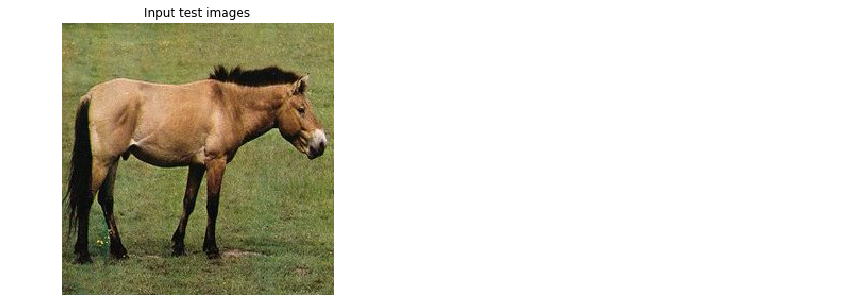

In [19]:
fixed_img_A = Image.open("data/test/testA/n02381460_3330.jpg")

fig = plt.figure(figsize=(15,5))
plt.axis("off")
fig.add_subplot(1,2,1)
plt.axis("off")
plt.title("Input test images")
plt.imshow(fixed_img_A)

plt.show()



In [20]:
transform_A = Variable(data_transform(fixed_img_A)).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)
#transform_B = Variable(data_transform(fixed_img_B)).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)

In [21]:
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_show = img.cpu().numpy().squeeze().transpose((1,2,0))
    img_show = (img_show * std+mean)
    img_show = np.clip(img_show,0,1)
    return img_show

In [22]:
def generate_img(G_A2B, G_B2A, img_A):
    G_A2B.eval()
    G_B2A.eval()
    
    
    with torch.no_grad():
        img_show = imshow(img_A)
        
        fake_B = G_A2B(img_A)
        fake_B_show = imshow(fake_B)
        
        fake_A = G_B2A(fake_B)
        fake_A_show = imshow(fake_A)
        
        
    fig = plt.figure(figsize=(30,10))
    plt.title("Generator test")
    plt.axis("off")
    fig.add_subplot(1,3,1)
    plt.axis("off")
    plt.title("Real")
    plt.imshow(img_show)
    fig.add_subplot(1,3,2)
    plt.axis("off")
    plt.title("Generated")
    plt.imshow(fake_B_show)
    fig.add_subplot(1,3,3)
    plt.axis("off")
    plt.title("Reconstructed")
    plt.imshow(fake_A_show)
    
    plt.show()
    G_A2B.train()
    G_B2A.train()

In [23]:
nc = 3
ngf = 64
ndf = 64
num_resnet = 6

In [24]:
# input_dim, num_filter, output_dim, num_resnet
G_A2B = Generator(nc, ngf, nc, num_resnet).to(device)
G_B2A = Generator(nc, ngf, nc, num_resnet).to(device)
#generate_img(G_A2B,G_B2A,transform_A)
def train(dataloader_A, dataloader_B):
    
    # input_dim, num_filter, output_dim
    D_A = Discriminator(nc, ndf, 1).to(device)
    D_B = Discriminator(nc, ndf, 1).to(device)

    G_A2B.normal_weight_init(mean=0.0, std=0.02)
    G_B2A.normal_weight_init(mean=0.0, std=0.02)
    D_A.normal_weight_init(mean=0.0, std=0.02)
    D_B.normal_weight_init(mean=0.0, std=0.02)

    G_A_optimizer = torch.optim.Adam(
        G_A2B.parameters(), lr=0.0002, betas=(0.5, 0.999))
    G_B_optimizer = torch.optim.Adam(
        G_B2A.parameters(), lr=0.0002, betas=(0.5, 0.999))
    D_A_optimizer = torch.optim.Adam(
        D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
    D_B_optimizer = torch.optim.Adam(
        D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

    MSE_error = nn.MSELoss()
    L1_error = nn.L1Loss()

    D_A_loss_list = []
    D_B_loss_list = []
    G_A_loss_list = []
    G_B_loss_list = []
    Cyclic_A_loss_list = []
    Cyclic_B_loss_list = []

    EPOCHS = 30

    print("Start training...")
    for epoch in range(EPOCHS):
        for i, (batch_A, batch_B) in enumerate(zip(dataloader_A, dataloader_B)):
            real_A = batch_A[0].to(device)
            real_B = batch_B[0].to(device)
            fake_A = G_B2A(real_A)
            fake_B = G_A2B(real_B)
            loss_G_A, loss_G_B, loss_cyclic_A, loss_cyclic_B = train_generator(D_A, D_B, G_A2B, G_B2A, G_A_optimizer, G_B_optimizer,
                                                                               MSE_error, L1_error, real_A, fake_A, real_B, fake_B)
            loss_D_A, loss_D_B = train_discriminator(D_A, D_B, G_A2B, G_B2A, D_A_optimizer, D_B_optimizer, MSE_error, L1_error, real_A,
                                                     fake_A, real_B, fake_B)

            D_A_loss_list.append(loss_D_A)
            D_B_loss_list.append(loss_D_B)
            G_A_loss_list.append(loss_G_A)
            G_B_loss_list.append(loss_G_B)
            Cyclic_A_loss_list.append(loss_cyclic_A)
            Cyclic_B_loss_list.append(loss_cyclic_B)

            if i % 360 == 0 or i == len(dataloader_A)-1:
                print("Epoch: ({}/{}) | Batch: ({}/{}) | D_A_Loss: {:.4f} D_B_Loss: {:.4f} | G_A_Loss: {:.4f} G_B_Loss: {:.4f} | C_A_Loss: {:.4f} C_B_Loss: {:.4f} |".format(
                    epoch+1, EPOCHS, i+1, len(dataloader_A), loss_D_A, loss_D_B, loss_G_A, loss_G_B, loss_cyclic_A, loss_cyclic_B))
        
        if epoch%3==0 or epoch == EPOCHS-1:
            ga_name = "model/generatorA-{}.pth".format(epoch)
            gb_name = "model/generatorB-{}.pth".format(epoch)
            torch.save(G_A2B.state_dict(), ga_name)
            torch.save(G_B2A.state_dict(), gb_name)
            generate_img(G_A2B, G_B2A, transform_A)
            
        if(epoch % 20 == 0 and epoch>0) :
            D_A_optimizer.param_groups[0]['lr'] -= 0.0002 / 100 
            D_B_optimizer.param_groups[0]['lr'] -= 0.0002 / 100 
            G_A_optimizer.param_groups[0]['lr'] -= 0.0002 / 100     
            G_B_optimizer.param_groups[0]['lr'] -= 0.0002 / 100
        
    print("Training Completed!")
    return G_A2B, G_B2A, D_A_loss_list, D_B_loss_list, G_A_loss_list, G_B_loss_list, Cyclic_A_loss_list, Cyclic_B_loss_list

Start training...
Epoch: (1/30) | Batch: (1/1067) | D_A_Loss: 6.8979 D_B_Loss: 6.0976 | G_A_Loss: 1.0660 G_B_Loss: 1.1945 | C_A_Loss: 16.0048 C_B_Loss: 14.0536 |
Epoch: (1/30) | Batch: (361/1067) | D_A_Loss: 0.3630 D_B_Loss: 0.8325 | G_A_Loss: 0.6046 G_B_Loss: 0.3644 | C_A_Loss: 11.3900 C_B_Loss: 8.1212 |
Epoch: (1/30) | Batch: (721/1067) | D_A_Loss: 0.7264 D_B_Loss: 0.5364 | G_A_Loss: 0.2351 G_B_Loss: 0.5560 | C_A_Loss: 8.6249 C_B_Loss: 14.2634 |
Epoch: (1/30) | Batch: (1067/1067) | D_A_Loss: 0.1522 D_B_Loss: 1.0722 | G_A_Loss: 0.2860 G_B_Loss: 0.7034 | C_A_Loss: 6.9094 C_B_Loss: 6.5883 |


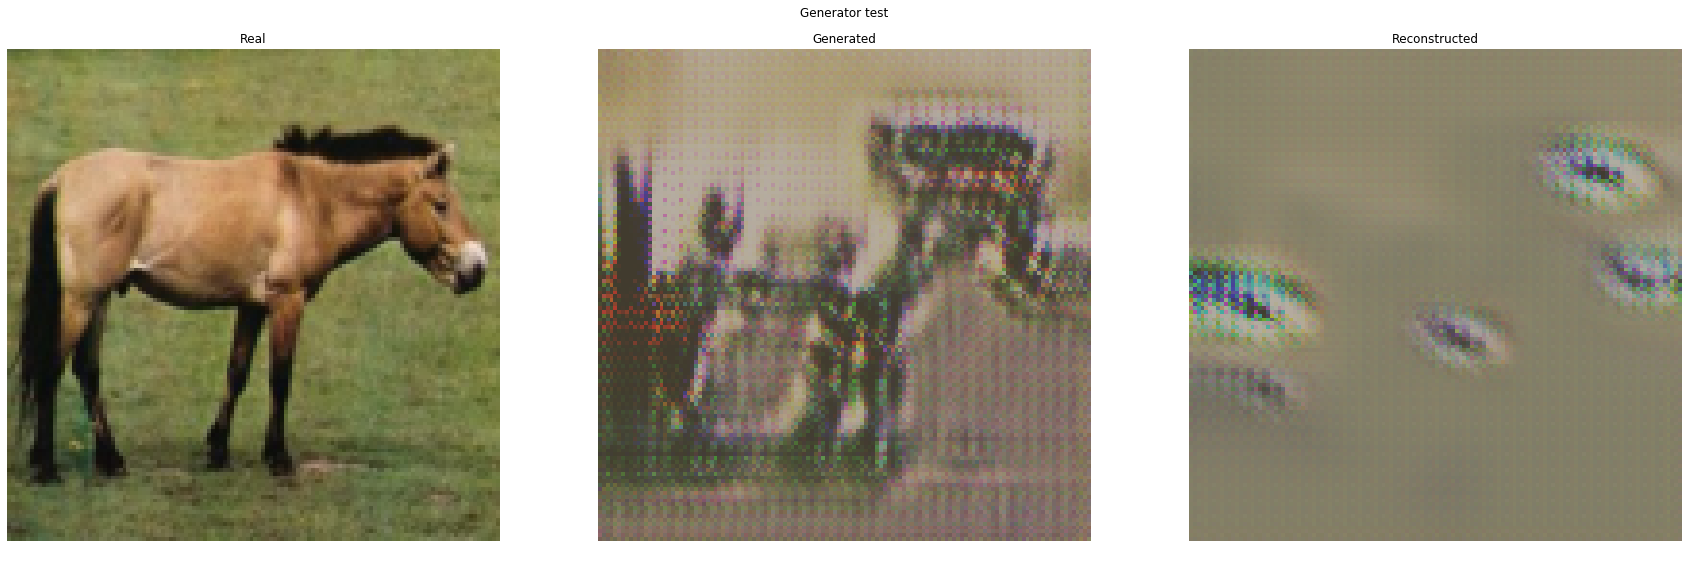

Epoch: (2/30) | Batch: (1/1067) | D_A_Loss: 2.1410 D_B_Loss: 0.4629 | G_A_Loss: 0.2233 G_B_Loss: 0.9327 | C_A_Loss: 7.8987 C_B_Loss: 5.4942 |
Epoch: (2/30) | Batch: (361/1067) | D_A_Loss: 1.8130 D_B_Loss: 0.3589 | G_A_Loss: 0.7550 G_B_Loss: 0.1933 | C_A_Loss: 5.9656 C_B_Loss: 9.5776 |
Epoch: (2/30) | Batch: (721/1067) | D_A_Loss: 0.2580 D_B_Loss: 0.3759 | G_A_Loss: 0.3142 G_B_Loss: 0.7300 | C_A_Loss: 8.3829 C_B_Loss: 7.3301 |
Epoch: (2/30) | Batch: (1067/1067) | D_A_Loss: 0.1008 D_B_Loss: 0.4533 | G_A_Loss: 0.5694 G_B_Loss: 0.9416 | C_A_Loss: 15.7181 C_B_Loss: 4.7537 |
Epoch: (3/30) | Batch: (1/1067) | D_A_Loss: 2.1993 D_B_Loss: 0.6099 | G_A_Loss: 0.6152 G_B_Loss: 0.9519 | C_A_Loss: 6.0783 C_B_Loss: 6.4791 |
Epoch: (3/30) | Batch: (361/1067) | D_A_Loss: 0.2537 D_B_Loss: 0.3287 | G_A_Loss: 0.3879 G_B_Loss: 0.8818 | C_A_Loss: 7.2614 C_B_Loss: 8.3258 |
Epoch: (3/30) | Batch: (721/1067) | D_A_Loss: 1.1354 D_B_Loss: 0.3200 | G_A_Loss: 0.8895 G_B_Loss: 0.4475 | C_A_Loss: 8.9468 C_B_Loss: 10.

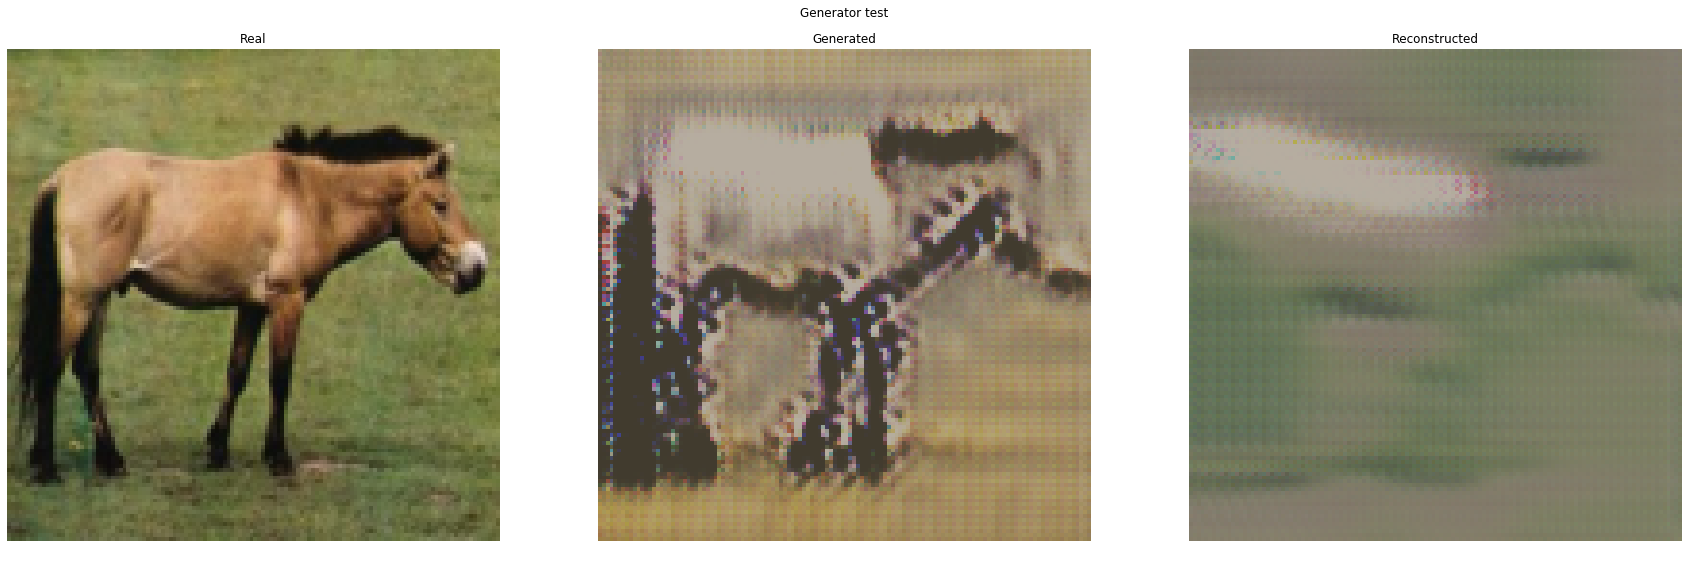

Epoch: (5/30) | Batch: (1/1067) | D_A_Loss: 0.0649 D_B_Loss: 1.2873 | G_A_Loss: 0.8506 G_B_Loss: 0.8062 | C_A_Loss: 14.1595 C_B_Loss: 9.4272 |
Epoch: (5/30) | Batch: (361/1067) | D_A_Loss: 0.1660 D_B_Loss: 0.1742 | G_A_Loss: 0.5579 G_B_Loss: 0.8493 | C_A_Loss: 10.0590 C_B_Loss: 8.4849 |
Epoch: (5/30) | Batch: (721/1067) | D_A_Loss: 0.0977 D_B_Loss: 0.7612 | G_A_Loss: 0.8592 G_B_Loss: 0.8619 | C_A_Loss: 10.1853 C_B_Loss: 5.4511 |
Epoch: (5/30) | Batch: (1067/1067) | D_A_Loss: 0.0780 D_B_Loss: 0.0617 | G_A_Loss: 0.7390 G_B_Loss: 0.7467 | C_A_Loss: 10.9469 C_B_Loss: 9.6598 |
Epoch: (6/30) | Batch: (1/1067) | D_A_Loss: 0.0888 D_B_Loss: 0.1814 | G_A_Loss: 0.8709 G_B_Loss: 0.8415 | C_A_Loss: 12.4045 C_B_Loss: 8.4459 |
Epoch: (6/30) | Batch: (361/1067) | D_A_Loss: 0.2916 D_B_Loss: 0.1874 | G_A_Loss: 0.7290 G_B_Loss: 0.5098 | C_A_Loss: 14.2855 C_B_Loss: 6.2507 |
Epoch: (6/30) | Batch: (721/1067) | D_A_Loss: 0.0569 D_B_Loss: 0.0962 | G_A_Loss: 0.6518 G_B_Loss: 0.7652 | C_A_Loss: 8.3250 C_B_Loss

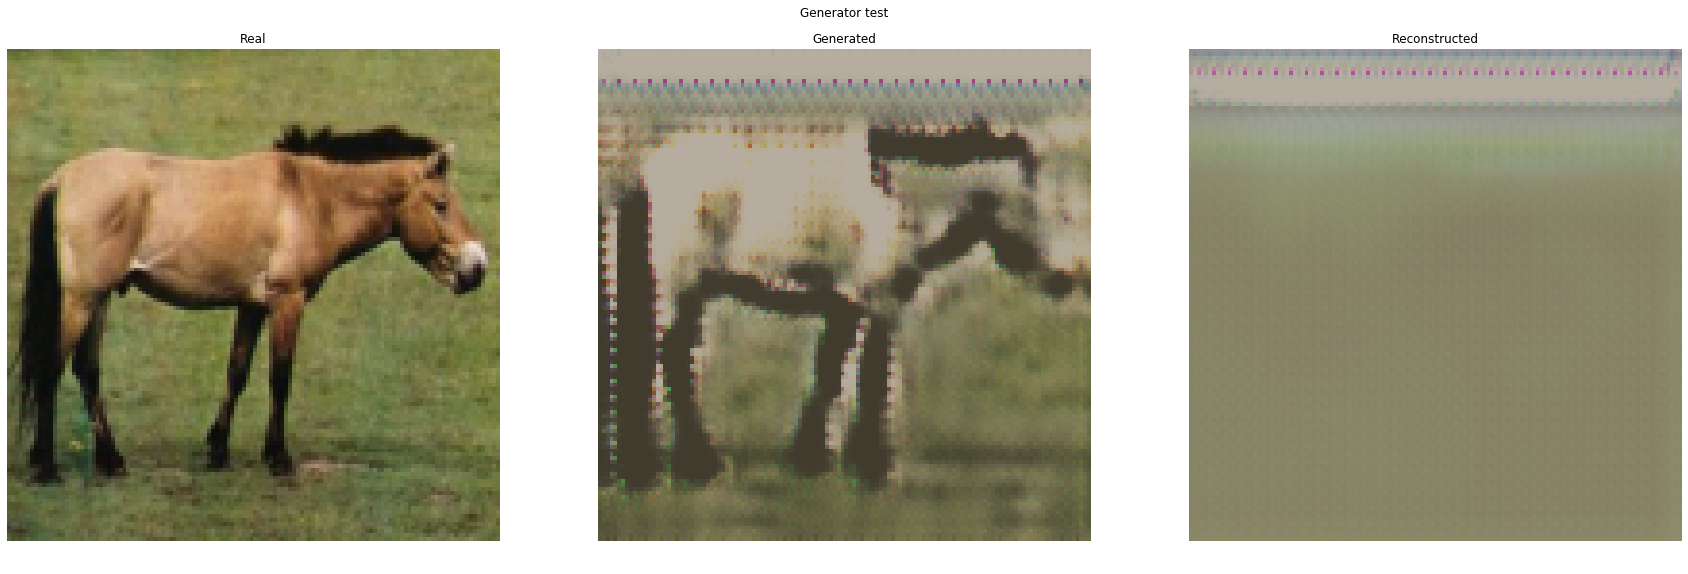

Epoch: (8/30) | Batch: (1/1067) | D_A_Loss: 0.0458 D_B_Loss: 0.0130 | G_A_Loss: 0.7688 G_B_Loss: 0.8043 | C_A_Loss: 11.3214 C_B_Loss: 5.2210 |
Epoch: (8/30) | Batch: (361/1067) | D_A_Loss: 0.0092 D_B_Loss: 0.0091 | G_A_Loss: 0.8214 G_B_Loss: 0.8062 | C_A_Loss: 11.0602 C_B_Loss: 6.1188 |
Epoch: (8/30) | Batch: (721/1067) | D_A_Loss: 0.0130 D_B_Loss: 0.0096 | G_A_Loss: 0.8030 G_B_Loss: 0.6541 | C_A_Loss: 7.5882 C_B_Loss: 12.3508 |
Epoch: (8/30) | Batch: (1067/1067) | D_A_Loss: 0.0306 D_B_Loss: 0.0088 | G_A_Loss: 0.8199 G_B_Loss: 0.7534 | C_A_Loss: 12.2148 C_B_Loss: 8.8018 |
Epoch: (9/30) | Batch: (1/1067) | D_A_Loss: 0.0264 D_B_Loss: 0.0084 | G_A_Loss: 0.8032 G_B_Loss: 0.7653 | C_A_Loss: 8.9579 C_B_Loss: 11.2759 |
Epoch: (9/30) | Batch: (361/1067) | D_A_Loss: 1.0896 D_B_Loss: 0.0051 | G_A_Loss: 0.8035 G_B_Loss: 0.3268 | C_A_Loss: 9.8630 C_B_Loss: 5.8533 |
Epoch: (9/30) | Batch: (721/1067) | D_A_Loss: 0.0129 D_B_Loss: 0.0069 | G_A_Loss: 0.8058 G_B_Loss: 0.8196 | C_A_Loss: 5.5076 C_B_Loss:

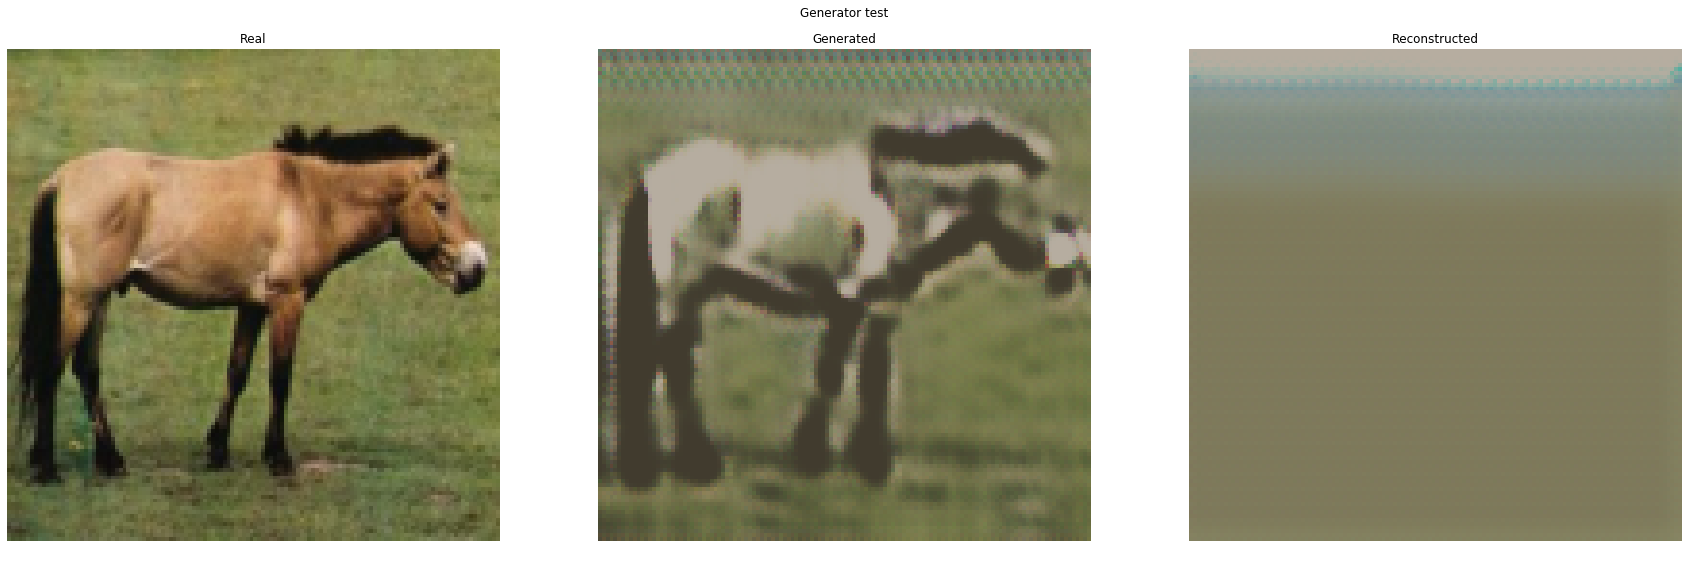

Epoch: (11/30) | Batch: (1/1067) | D_A_Loss: 0.0061 D_B_Loss: 0.0050 | G_A_Loss: 0.7868 G_B_Loss: 0.7723 | C_A_Loss: 10.6280 C_B_Loss: 16.1298 |
Epoch: (11/30) | Batch: (361/1067) | D_A_Loss: 0.0039 D_B_Loss: 0.0034 | G_A_Loss: 0.8227 G_B_Loss: 0.8198 | C_A_Loss: 6.3433 C_B_Loss: 6.5054 |
Epoch: (11/30) | Batch: (721/1067) | D_A_Loss: 0.0075 D_B_Loss: 0.0111 | G_A_Loss: 0.8323 G_B_Loss: 0.8264 | C_A_Loss: 12.1617 C_B_Loss: 9.5295 |
Epoch: (11/30) | Batch: (1067/1067) | D_A_Loss: 0.0045 D_B_Loss: 0.0091 | G_A_Loss: 0.8342 G_B_Loss: 0.8093 | C_A_Loss: 9.3222 C_B_Loss: 8.4939 |
Epoch: (12/30) | Batch: (1/1067) | D_A_Loss: 0.0049 D_B_Loss: 0.0157 | G_A_Loss: 0.7509 G_B_Loss: 0.8002 | C_A_Loss: 8.6806 C_B_Loss: 6.8917 |
Epoch: (12/30) | Batch: (361/1067) | D_A_Loss: 0.0046 D_B_Loss: 0.0387 | G_A_Loss: 0.9094 G_B_Loss: 0.8237 | C_A_Loss: 7.4079 C_B_Loss: 10.7853 |
Epoch: (12/30) | Batch: (721/1067) | D_A_Loss: 0.0050 D_B_Loss: 0.0053 | G_A_Loss: 0.8166 G_B_Loss: 0.8106 | C_A_Loss: 7.2931 C_B

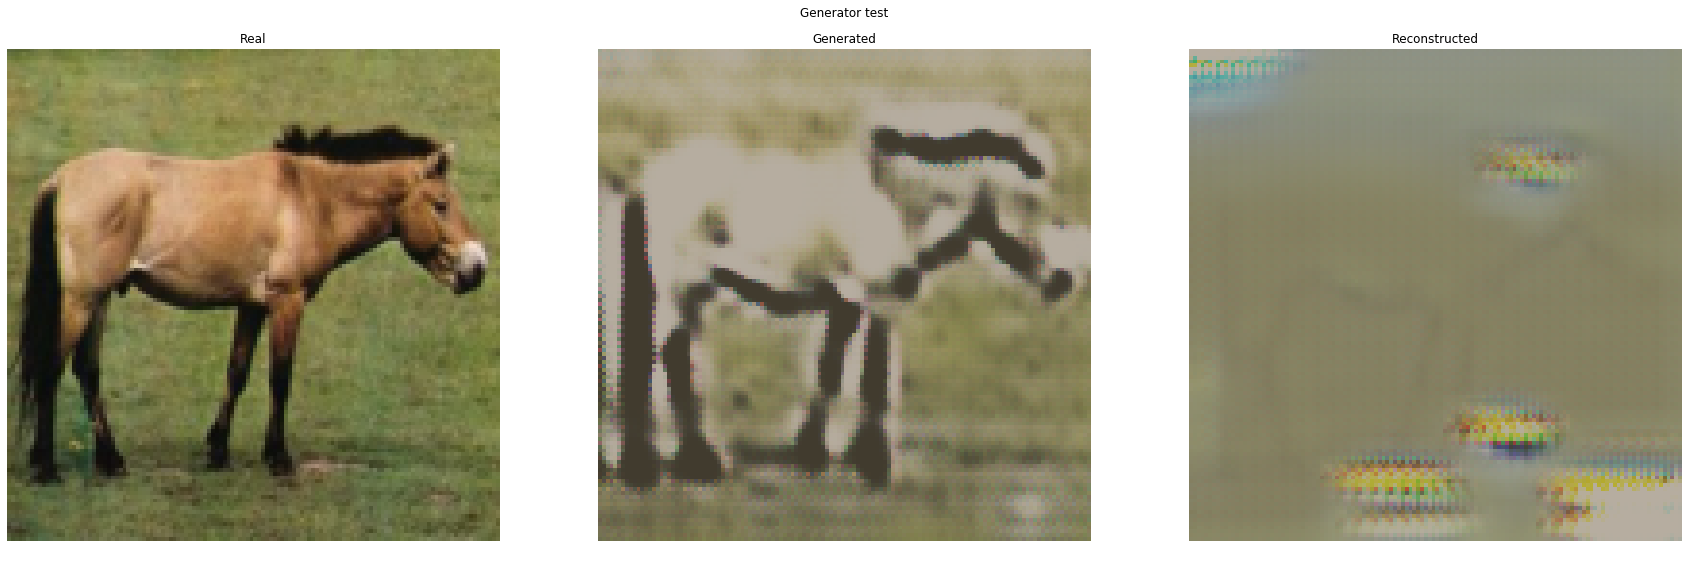

Epoch: (14/30) | Batch: (1/1067) | D_A_Loss: 0.0053 D_B_Loss: 0.2172 | G_A_Loss: 0.3716 G_B_Loss: 0.8213 | C_A_Loss: 5.6351 C_B_Loss: 8.5520 |
Epoch: (14/30) | Batch: (361/1067) | D_A_Loss: 0.0044 D_B_Loss: 0.0046 | G_A_Loss: 0.7909 G_B_Loss: 0.8062 | C_A_Loss: 7.9381 C_B_Loss: 7.6798 |
Epoch: (14/30) | Batch: (721/1067) | D_A_Loss: 0.0031 D_B_Loss: 0.0013 | G_A_Loss: 0.8097 G_B_Loss: 0.8175 | C_A_Loss: 9.3168 C_B_Loss: 6.7471 |
Epoch: (14/30) | Batch: (1067/1067) | D_A_Loss: 0.0076 D_B_Loss: 0.0016 | G_A_Loss: 0.8083 G_B_Loss: 0.7954 | C_A_Loss: 9.8894 C_B_Loss: 9.8958 |
Epoch: (15/30) | Batch: (1/1067) | D_A_Loss: 0.0114 D_B_Loss: 0.0008 | G_A_Loss: 0.8093 G_B_Loss: 0.8277 | C_A_Loss: 6.9582 C_B_Loss: 5.9319 |
Epoch: (15/30) | Batch: (361/1067) | D_A_Loss: 0.0069 D_B_Loss: 0.0010 | G_A_Loss: 0.8119 G_B_Loss: 0.8063 | C_A_Loss: 11.5344 C_B_Loss: 9.8082 |
Epoch: (15/30) | Batch: (721/1067) | D_A_Loss: 0.0015 D_B_Loss: 0.0133 | G_A_Loss: 0.7989 G_B_Loss: 0.8098 | C_A_Loss: 10.5598 C_B_L

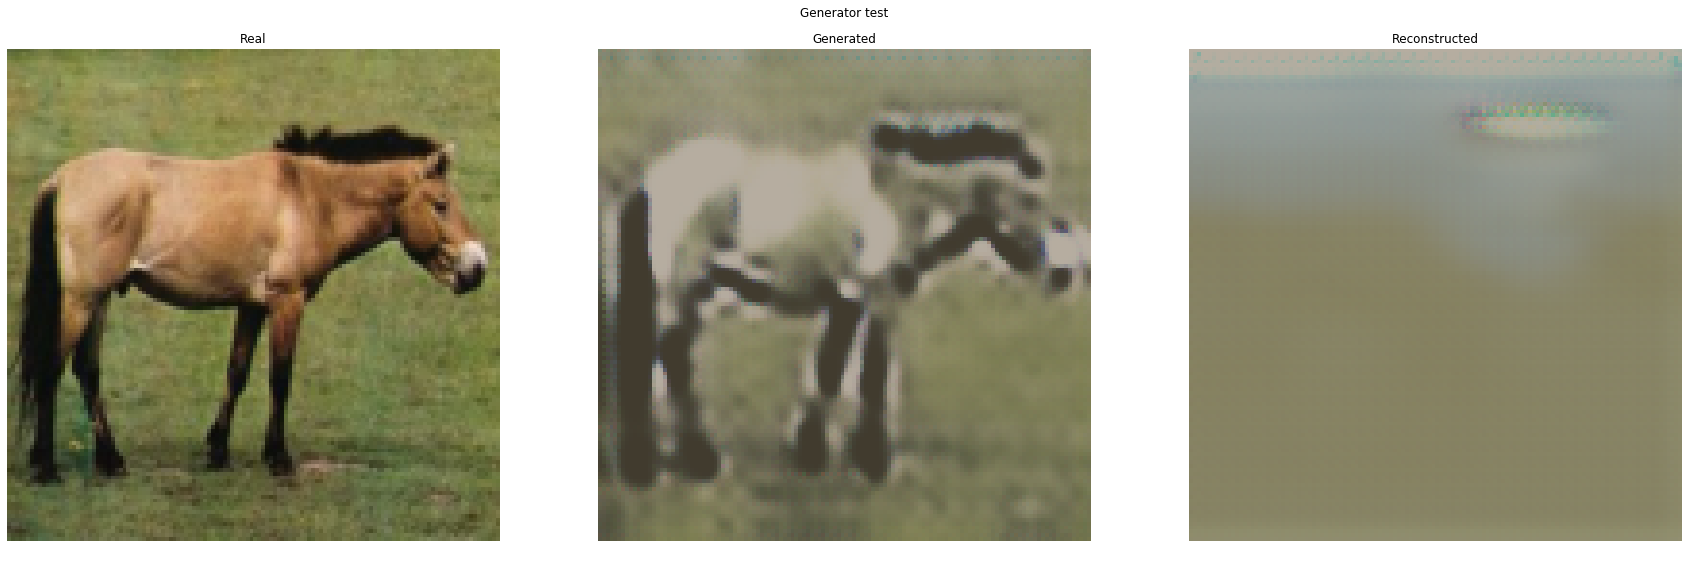

Epoch: (17/30) | Batch: (1/1067) | D_A_Loss: 0.0042 D_B_Loss: 0.0016 | G_A_Loss: 0.8123 G_B_Loss: 0.7997 | C_A_Loss: 7.9684 C_B_Loss: 5.1114 |
Epoch: (17/30) | Batch: (361/1067) | D_A_Loss: 0.0033 D_B_Loss: 0.0011 | G_A_Loss: 0.8084 G_B_Loss: 0.8343 | C_A_Loss: 10.4734 C_B_Loss: 15.5149 |
Epoch: (17/30) | Batch: (721/1067) | D_A_Loss: 0.0107 D_B_Loss: 0.0015 | G_A_Loss: 0.8164 G_B_Loss: 0.8676 | C_A_Loss: 11.0920 C_B_Loss: 11.9672 |
Epoch: (17/30) | Batch: (1067/1067) | D_A_Loss: 0.0257 D_B_Loss: 0.0064 | G_A_Loss: 0.7957 G_B_Loss: 0.8873 | C_A_Loss: 9.0968 C_B_Loss: 10.4784 |
Epoch: (18/30) | Batch: (1/1067) | D_A_Loss: 0.0123 D_B_Loss: 0.0065 | G_A_Loss: 0.8355 G_B_Loss: 0.7655 | C_A_Loss: 7.3737 C_B_Loss: 9.5218 |
Epoch: (18/30) | Batch: (361/1067) | D_A_Loss: 1.6744 D_B_Loss: 0.0056 | G_A_Loss: 0.8370 G_B_Loss: 0.8913 | C_A_Loss: 4.3436 C_B_Loss: 12.9988 |
Epoch: (18/30) | Batch: (721/1067) | D_A_Loss: 0.0113 D_B_Loss: 0.0159 | G_A_Loss: 0.7595 G_B_Loss: 0.8084 | C_A_Loss: 7.9985 C

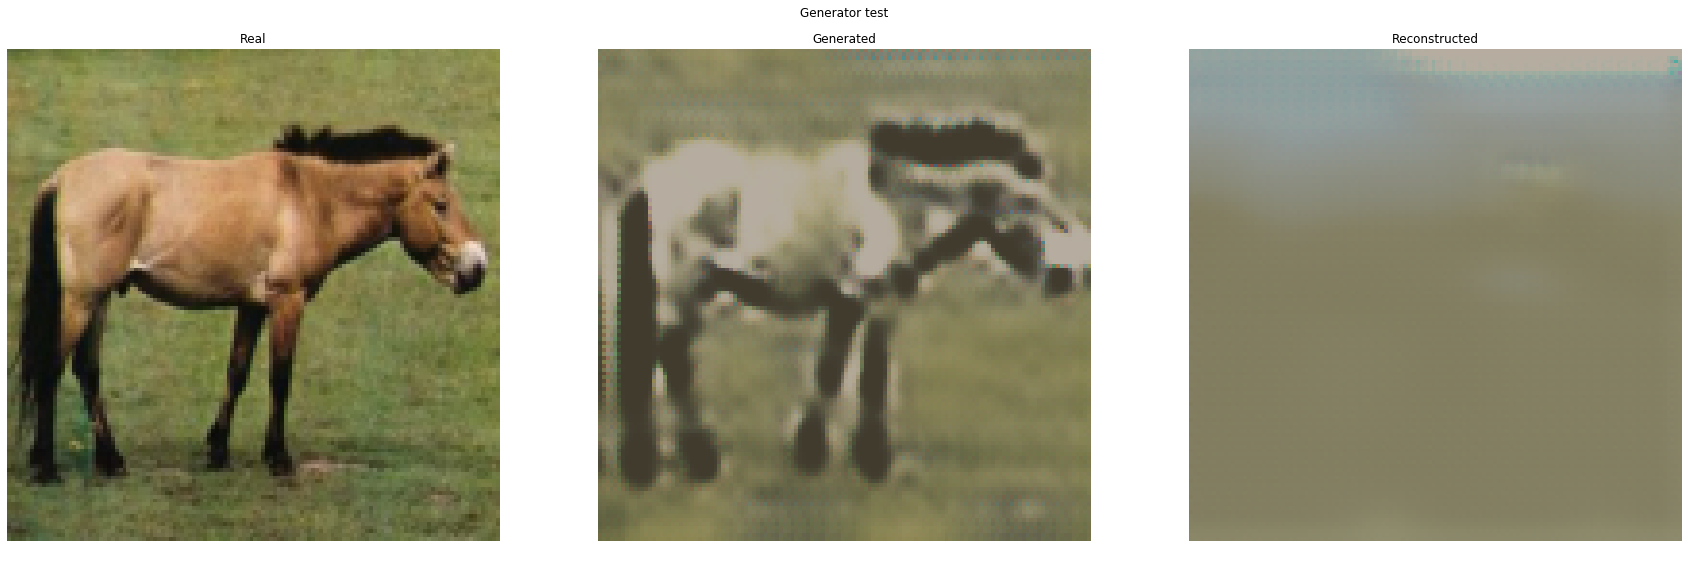

Epoch: (20/30) | Batch: (1/1067) | D_A_Loss: 0.0024 D_B_Loss: 0.0024 | G_A_Loss: 0.8224 G_B_Loss: 0.8294 | C_A_Loss: 8.3319 C_B_Loss: 8.4358 |
Epoch: (20/30) | Batch: (361/1067) | D_A_Loss: 0.0016 D_B_Loss: 0.0013 | G_A_Loss: 0.8116 G_B_Loss: 0.8041 | C_A_Loss: 10.2634 C_B_Loss: 11.7156 |
Epoch: (20/30) | Batch: (721/1067) | D_A_Loss: 0.0054 D_B_Loss: 0.0018 | G_A_Loss: 0.8197 G_B_Loss: 0.7832 | C_A_Loss: 4.7833 C_B_Loss: 8.0623 |
Epoch: (20/30) | Batch: (1067/1067) | D_A_Loss: 0.0067 D_B_Loss: 0.0051 | G_A_Loss: 0.8192 G_B_Loss: 0.7880 | C_A_Loss: 4.7492 C_B_Loss: 10.1684 |
Epoch: (21/30) | Batch: (1/1067) | D_A_Loss: 0.0030 D_B_Loss: 0.0064 | G_A_Loss: 0.8008 G_B_Loss: 0.8150 | C_A_Loss: 5.3010 C_B_Loss: 5.4646 |
Epoch: (21/30) | Batch: (361/1067) | D_A_Loss: 0.0011 D_B_Loss: 0.0015 | G_A_Loss: 0.8128 G_B_Loss: 0.8149 | C_A_Loss: 3.9836 C_B_Loss: 6.1097 |
Epoch: (21/30) | Batch: (721/1067) | D_A_Loss: 0.0084 D_B_Loss: 0.0115 | G_A_Loss: 0.8466 G_B_Loss: 0.8334 | C_A_Loss: 7.7039 C_B_

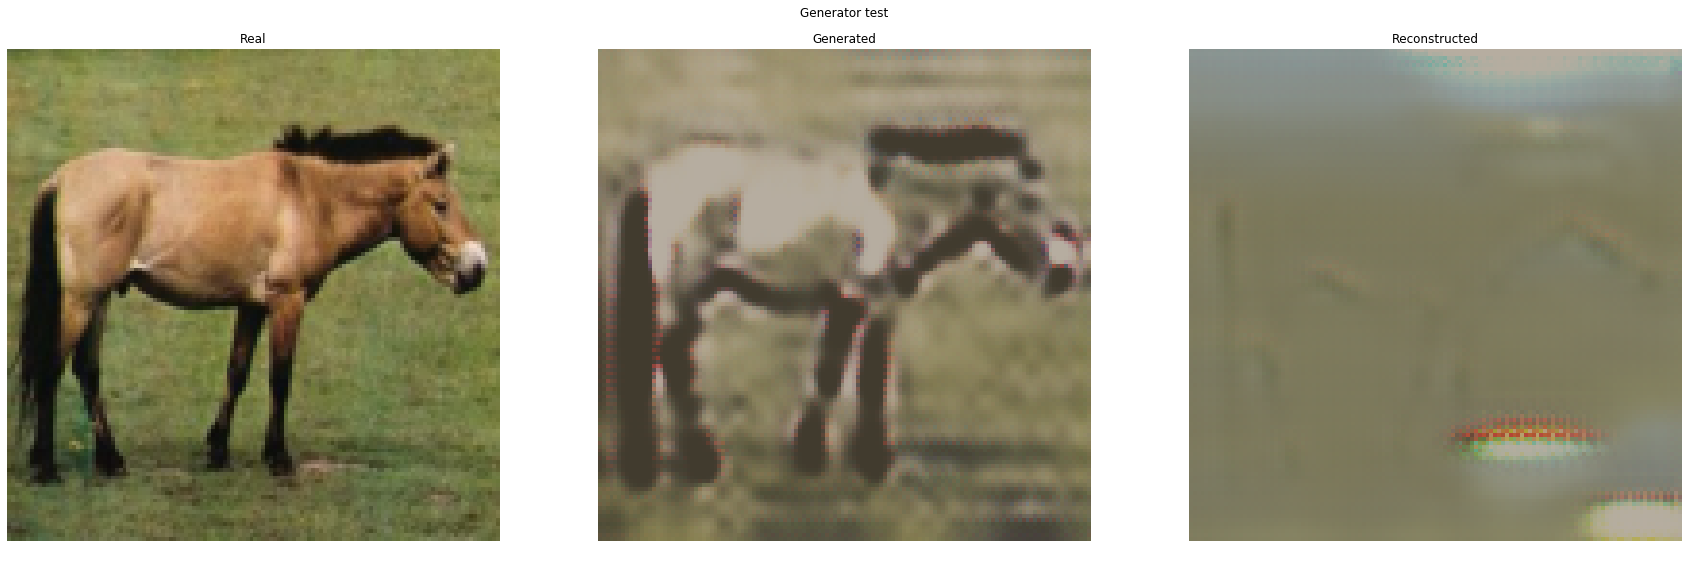

Epoch: (23/30) | Batch: (1/1067) | D_A_Loss: 0.0100 D_B_Loss: 0.0016 | G_A_Loss: 0.8271 G_B_Loss: 0.7678 | C_A_Loss: 11.9073 C_B_Loss: 4.6467 |
Epoch: (23/30) | Batch: (361/1067) | D_A_Loss: 0.0032 D_B_Loss: 0.0070 | G_A_Loss: 0.8100 G_B_Loss: 0.8136 | C_A_Loss: 8.8533 C_B_Loss: 8.3355 |
Epoch: (23/30) | Batch: (721/1067) | D_A_Loss: 0.0030 D_B_Loss: 0.0030 | G_A_Loss: 0.8220 G_B_Loss: 0.8265 | C_A_Loss: 5.7404 C_B_Loss: 12.2599 |
Epoch: (23/30) | Batch: (1067/1067) | D_A_Loss: 0.0015 D_B_Loss: 0.0056 | G_A_Loss: 0.8265 G_B_Loss: 0.8196 | C_A_Loss: 9.3545 C_B_Loss: 6.9852 |
Epoch: (24/30) | Batch: (1/1067) | D_A_Loss: 0.0013 D_B_Loss: 0.0089 | G_A_Loss: 0.7829 G_B_Loss: 0.8095 | C_A_Loss: 9.6370 C_B_Loss: 9.0704 |
Epoch: (24/30) | Batch: (361/1067) | D_A_Loss: 0.2992 D_B_Loss: 0.0023 | G_A_Loss: 0.8186 G_B_Loss: 0.7085 | C_A_Loss: 11.1865 C_B_Loss: 6.0711 |
Epoch: (24/30) | Batch: (721/1067) | D_A_Loss: 0.0698 D_B_Loss: 0.0041 | G_A_Loss: 0.8428 G_B_Loss: 0.8444 | C_A_Loss: 6.4182 C_B_

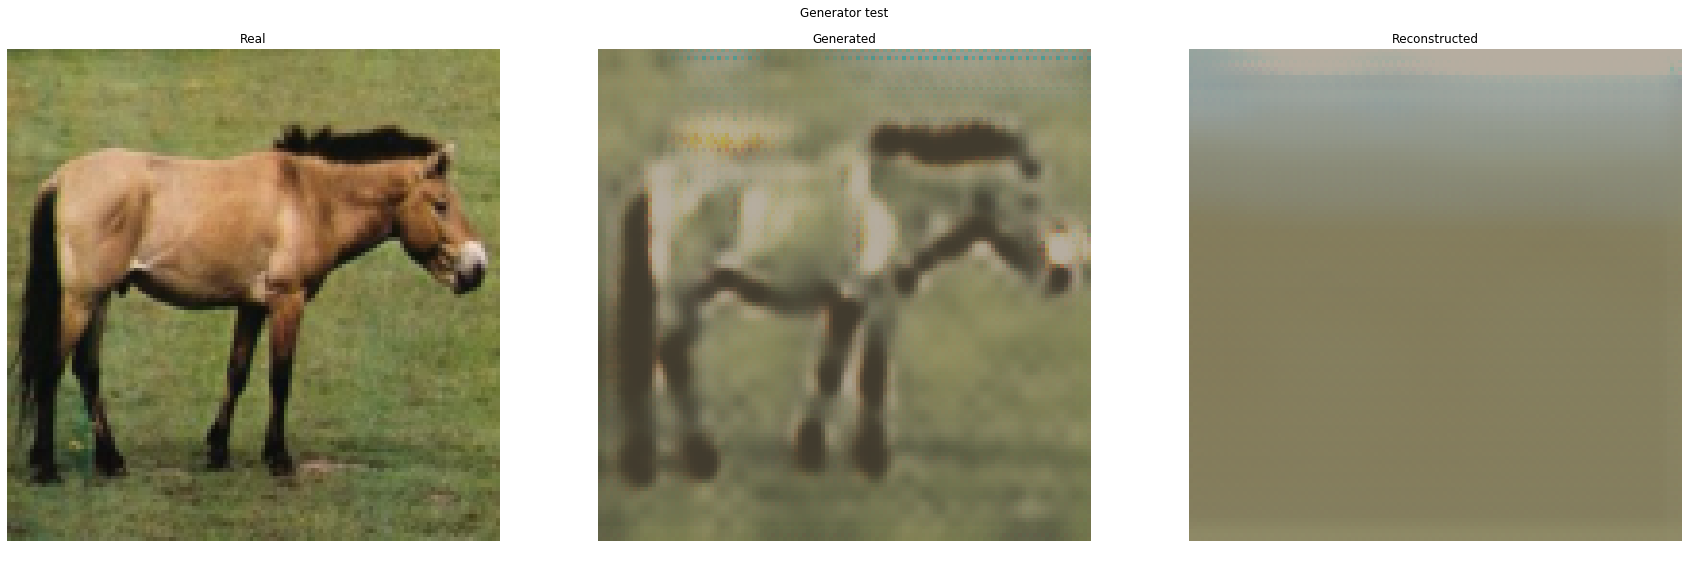

Epoch: (26/30) | Batch: (1/1067) | D_A_Loss: 0.0014 D_B_Loss: 0.0030 | G_A_Loss: 0.7836 G_B_Loss: 0.8213 | C_A_Loss: 11.4607 C_B_Loss: 12.9173 |
Epoch: (26/30) | Batch: (361/1067) | D_A_Loss: 0.0014 D_B_Loss: 0.0083 | G_A_Loss: 0.7670 G_B_Loss: 0.8056 | C_A_Loss: 8.1468 C_B_Loss: 6.1499 |
Epoch: (26/30) | Batch: (721/1067) | D_A_Loss: 0.0010 D_B_Loss: 0.0006 | G_A_Loss: 0.8030 G_B_Loss: 0.8151 | C_A_Loss: 6.4826 C_B_Loss: 8.3535 |
Epoch: (26/30) | Batch: (1067/1067) | D_A_Loss: 0.0009 D_B_Loss: 0.0011 | G_A_Loss: 0.7984 G_B_Loss: 0.8120 | C_A_Loss: 5.7577 C_B_Loss: 11.2618 |
Epoch: (27/30) | Batch: (1/1067) | D_A_Loss: 0.0013 D_B_Loss: 0.0006 | G_A_Loss: 0.8198 G_B_Loss: 0.8100 | C_A_Loss: 10.1437 C_B_Loss: 4.0996 |
Epoch: (27/30) | Batch: (361/1067) | D_A_Loss: 0.0009 D_B_Loss: 0.0021 | G_A_Loss: 0.7960 G_B_Loss: 0.8082 | C_A_Loss: 11.4139 C_B_Loss: 4.9063 |
Epoch: (27/30) | Batch: (721/1067) | D_A_Loss: 0.0013 D_B_Loss: 0.0006 | G_A_Loss: 0.8190 G_B_Loss: 0.8097 | C_A_Loss: 7.1928 C_

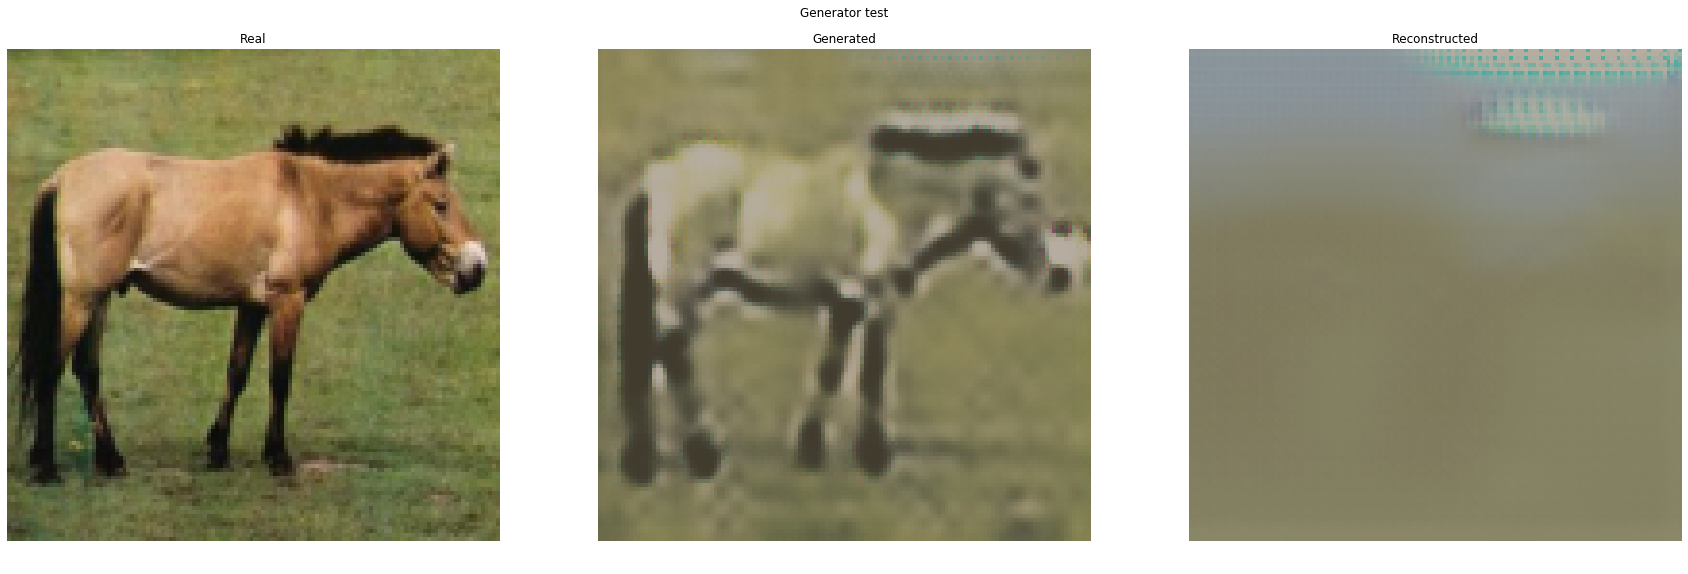

Epoch: (29/30) | Batch: (1/1067) | D_A_Loss: 0.0648 D_B_Loss: 0.0003 | G_A_Loss: 0.8138 G_B_Loss: 0.7901 | C_A_Loss: 10.2267 C_B_Loss: 5.6023 |
Epoch: (29/30) | Batch: (361/1067) | D_A_Loss: 0.2668 D_B_Loss: 0.0005 | G_A_Loss: 0.8055 G_B_Loss: 0.4862 | C_A_Loss: 6.9542 C_B_Loss: 8.3906 |
Epoch: (29/30) | Batch: (721/1067) | D_A_Loss: 0.0211 D_B_Loss: 0.0002 | G_A_Loss: 0.8093 G_B_Loss: 0.7613 | C_A_Loss: 5.3461 C_B_Loss: 6.8450 |
Epoch: (29/30) | Batch: (1067/1067) | D_A_Loss: 0.2894 D_B_Loss: 0.0015 | G_A_Loss: 0.8141 G_B_Loss: 0.4799 | C_A_Loss: 4.8713 C_B_Loss: 7.4365 |
Epoch: (30/30) | Batch: (1/1067) | D_A_Loss: 0.0785 D_B_Loss: 0.0020 | G_A_Loss: 0.8004 G_B_Loss: 0.1139 | C_A_Loss: 8.3011 C_B_Loss: 11.5631 |
Epoch: (30/30) | Batch: (361/1067) | D_A_Loss: 0.0234 D_B_Loss: 0.0023 | G_A_Loss: 0.8326 G_B_Loss: 0.5700 | C_A_Loss: 12.2820 C_B_Loss: 7.1095 |
Epoch: (30/30) | Batch: (721/1067) | D_A_Loss: 0.0095 D_B_Loss: 0.0006 | G_A_Loss: 0.8091 G_B_Loss: 0.7924 | C_A_Loss: 11.1040 C_B

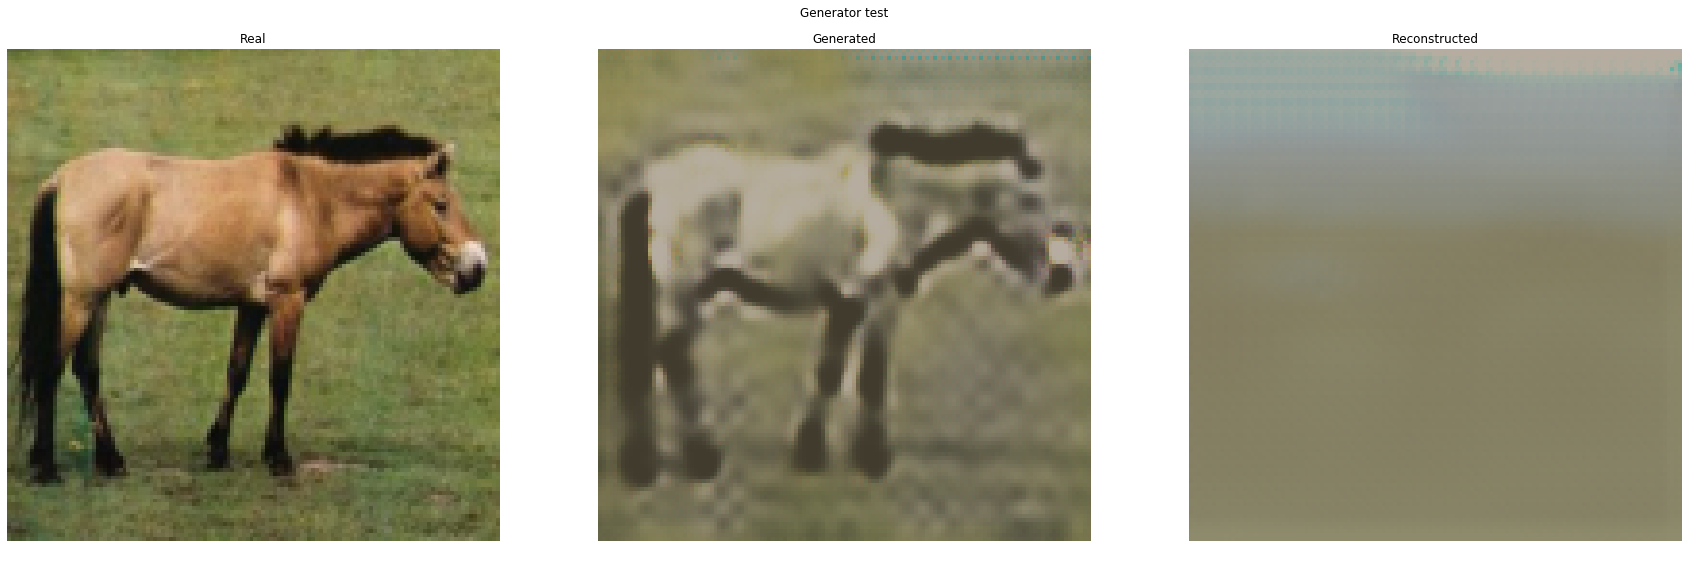

Training Completed!


In [25]:
if TRAIN_DATA:
    G_A2B, G_B2A, D_A_loss_list, D_B_loss_list, G_A_loss_list, G_B_loss_list, Cyclic_A_loss_list, Cyclic_B_loss_list = train(
        dataloader_A, dataloader_B)
    

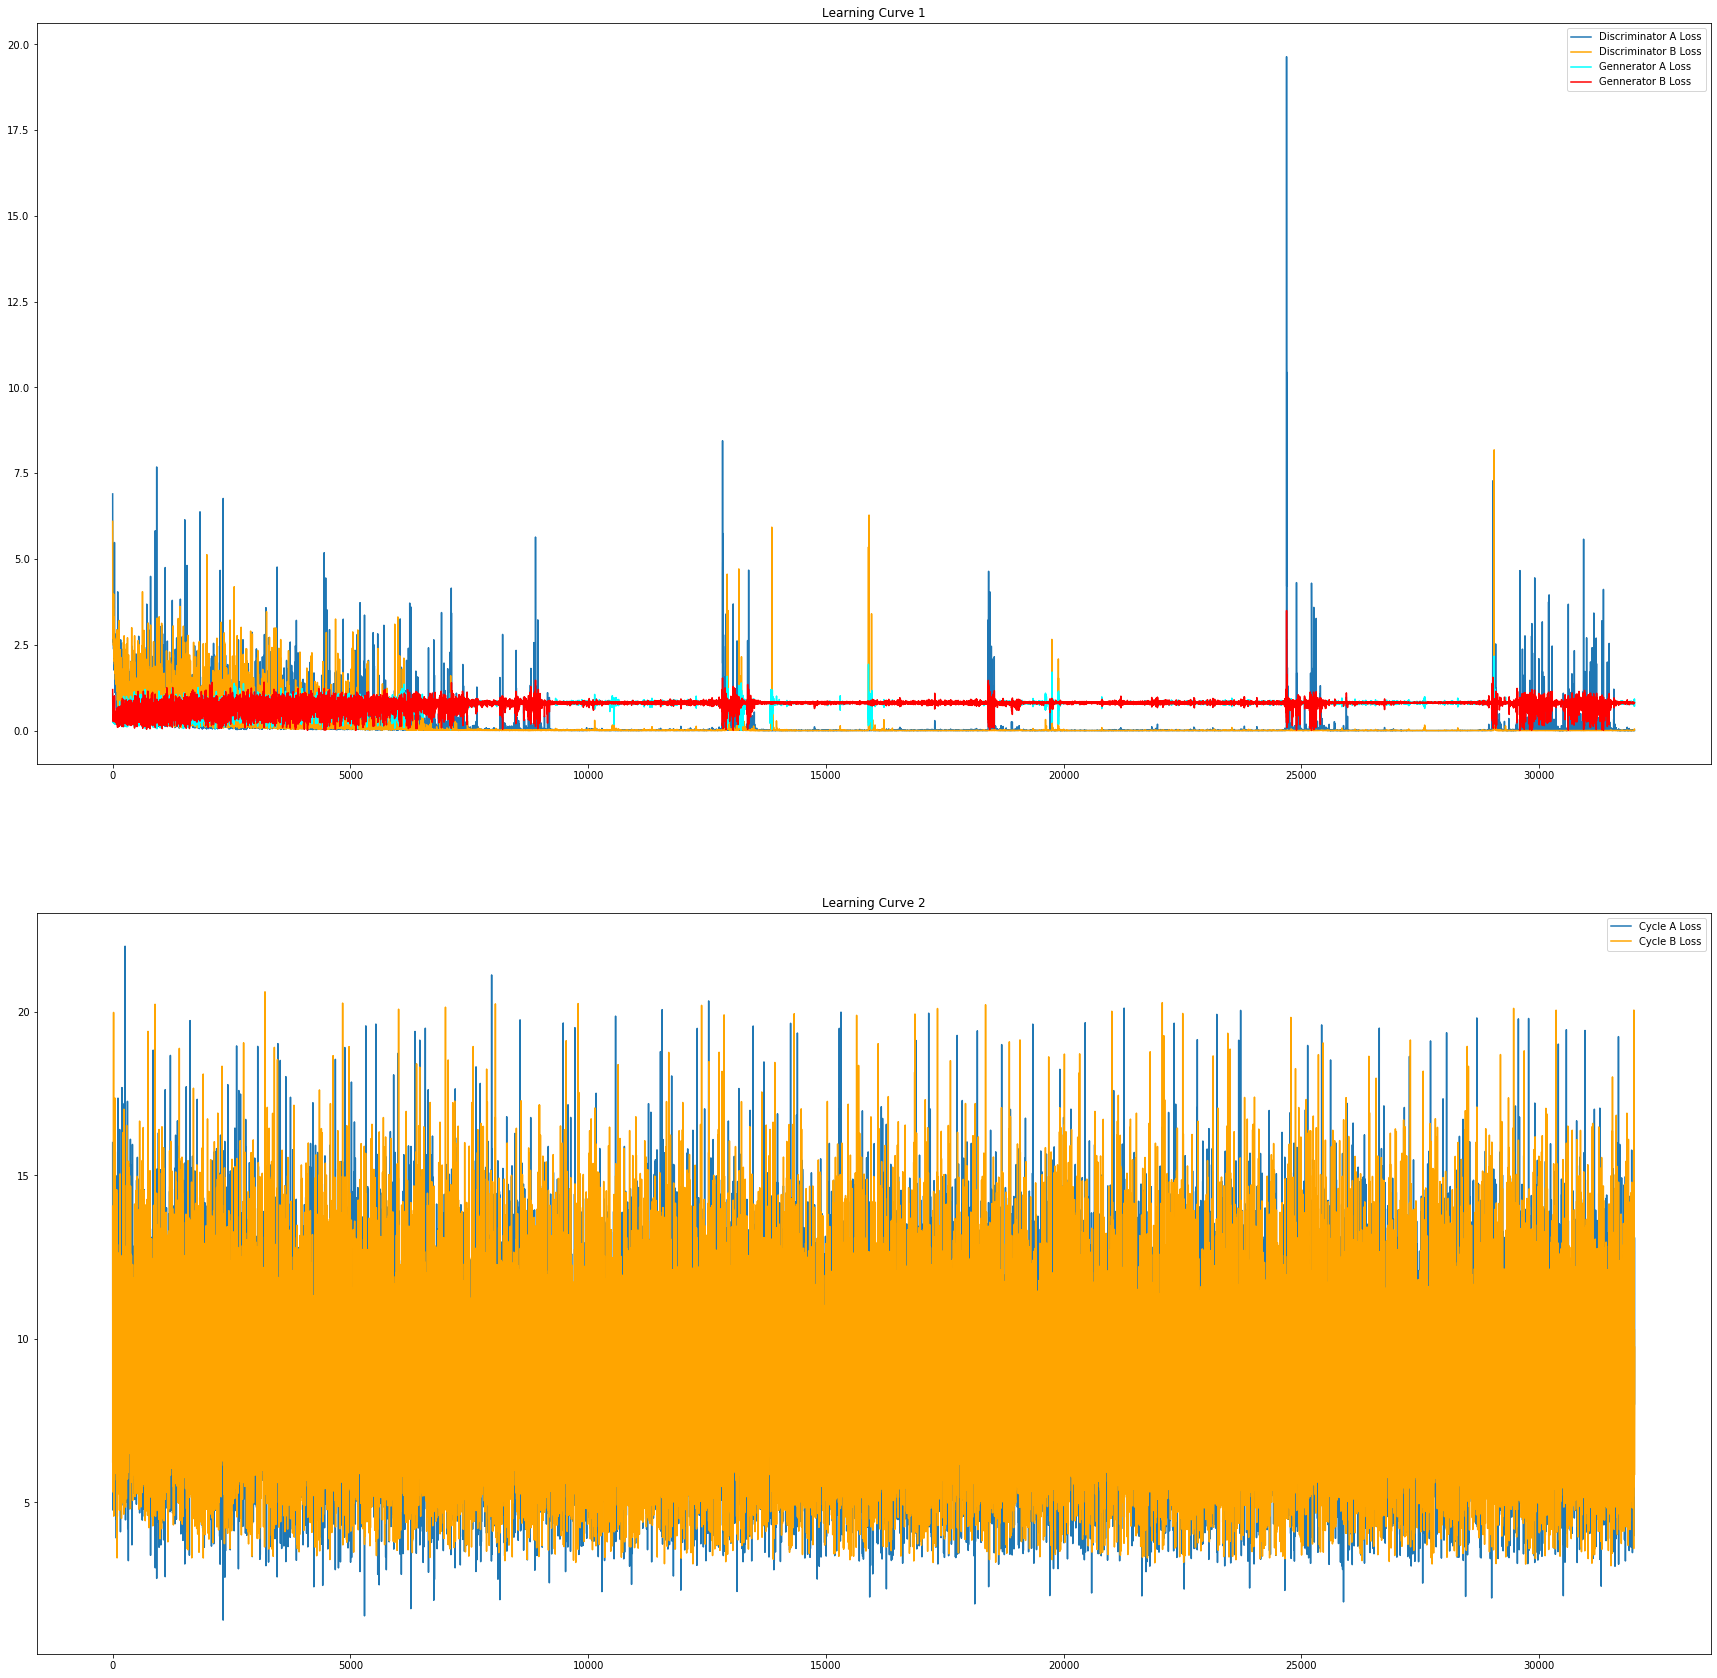

In [29]:
#Plot learning curves
def plot(D_A_loss_list, D_B_loss_list, G_A_loss_list, G_B_loss_list, Cyclic_A_loss_list, Cyclic_B_loss_list, EPOCHS=None):
    if EPOCHS is None:
        EPOCHS = len(D_A_loss_list)
    fig = plt.figure(figsize=(30,30))
    fig.add_subplot(2,1,1)
    plt.plot(range(EPOCHS), D_A_loss_list,label = "Discriminator A Loss")
    plt.plot(range(EPOCHS),D_B_loss_list, color ="orange",label = "Discriminator B Loss")
    plt.plot(range(EPOCHS),G_A_loss_list, color ="cyan",label = "Gennerator A Loss")
    plt.plot(range(EPOCHS),G_B_loss_list, color ="red",label = "Gennerator B Loss")
    plt.title("Learning Curve 1")
    plt.legend()
    
    fig.add_subplot(2,1,2)
    plt.plot(range(EPOCHS), Cyclic_A_loss_list,label = "Cycle A Loss")
    plt.plot(range(EPOCHS), Cyclic_B_loss_list, color ="orange",label = "Cycle B Loss")
    plt.title("Learning Curve 2")
    plt.legend()
    plt.show()
if TRAIN_DATA: 
    plot(D_A_loss_list, D_B_loss_list, G_A_loss_list, G_B_loss_list, Cyclic_A_loss_list, Cyclic_B_loss_list)

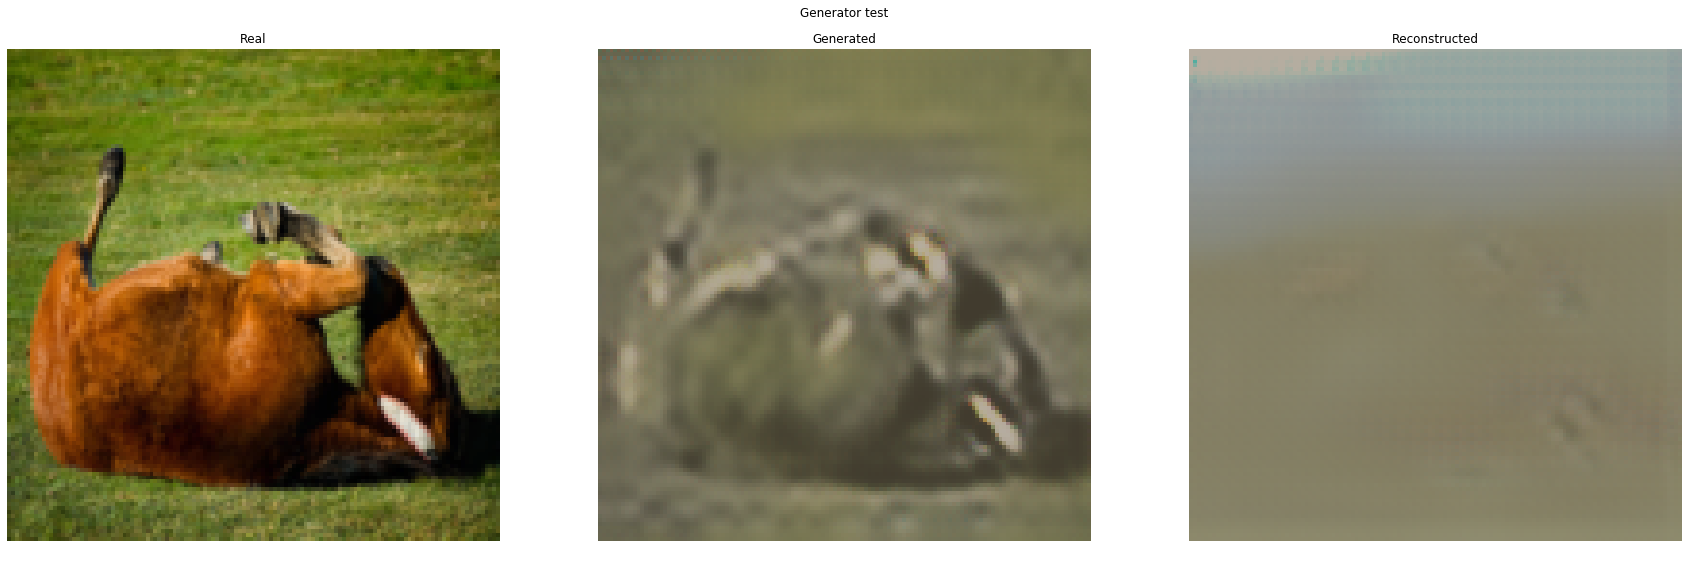

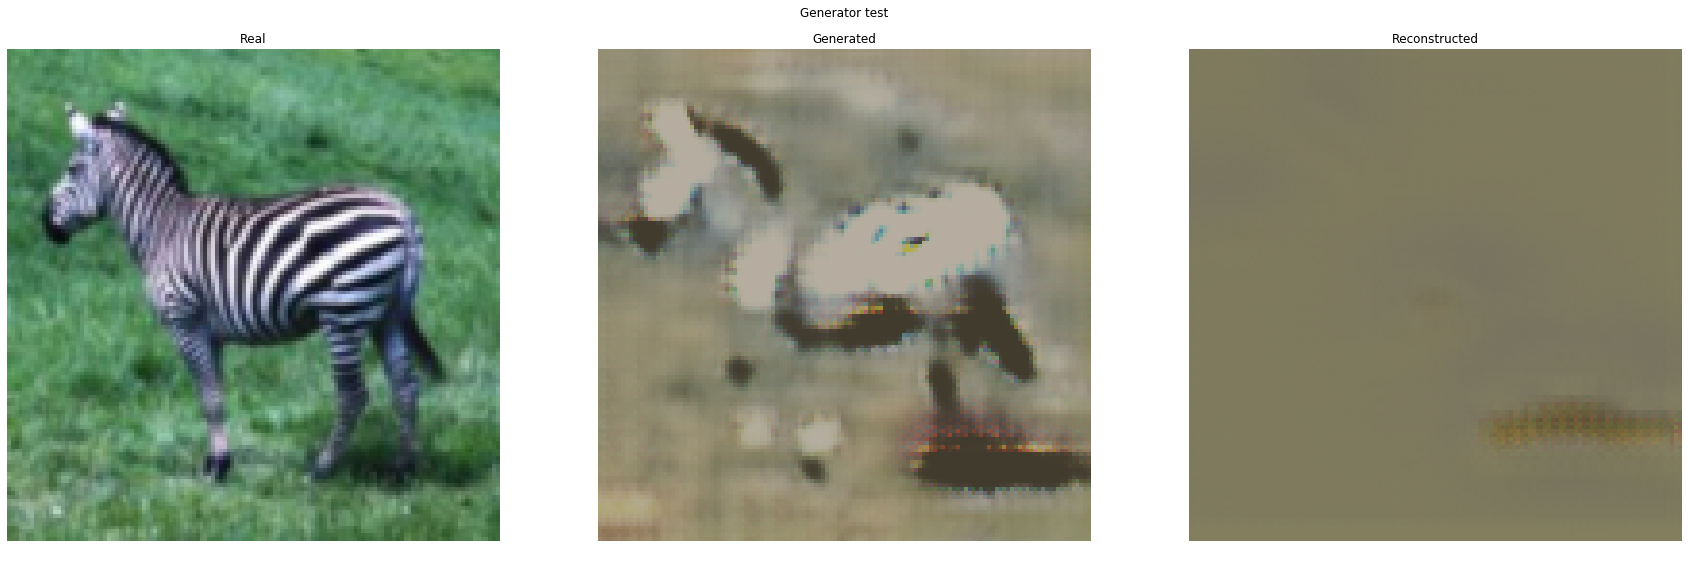

In [45]:
def test_generator(img,G_A2B,G_B2A, domain):
    img = Variable(data_transform(img)).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)
    with torch.no_grad():
        img_show = imshow(img)
        if domain == "A":
            fake = G_A2B(img)
            fake_show = imshow(fake)
            reconstructed = G_B2A(fake)
            reconstructed_show = imshow(reconstructed)
        else:
            fake = G_B2A(img)
            fake_show = imshow(fake)
            reconstructed = G_A2B(fake)
            reconstructed_show = imshow(reconstructed)


    fig = plt.figure(figsize=(30,10))
    plt.title("Generator test")
    plt.axis("off")
    fig.add_subplot(1,3,1)
    plt.axis("off")
    plt.title("Real")
    plt.imshow(img_show)
    fig.add_subplot(1,3,2)
    plt.axis("off")
    plt.title("Generated")
    plt.imshow(fake_show)
    fig.add_subplot(1,3,3)
    plt.axis("off")
    plt.title("Reconstructed")
    plt.imshow(reconstructed_show)
    plt.show()
    
test_A = Image.open("data/test/testA/n02381460_4660.jpg")
test_B = Image.open("data/test/testB/n02391049_4890.jpg")

test_generator(test_A,G_A2B,G_B2A,"A")
test_generator(test_B,G_A2B,G_B2A,"B")